## Part 0: Setting things up -- libraries and functions

### Loading needed libraries

In [1]:
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/surya/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

### Plotting functions

In [2]:
### Plotting the results
def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize)/kernelSize, 'valid')
    return array

def plot_dqn(obj, title = 'DQN'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(311)
    plt.plot(convolve(obj.loss_vec, kernelSize=11)/11)
    plt.title(title+' loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(312)
    plt.plot(convolve(obj.loss_vec, kernelSize=111)/111)
    plt.title(title+' smoothed loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(313)
    plt.plot(np.array(obj.returns)[:,0],np.array(obj.returns)[:,1])
    plt.xlabel('timesteps'), plt.ylabel('return')
    plt.title(title+' training performance')
    plt.show()

def plot_dsr(obj, title='DSR'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(211)
    plt.plot(convolve(obj.loss_q_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss q value'), plt.xlabel('batch no')
    plt.subplot(212)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')
    
def plot_dsr2(obj, title='DSR'):
    plt.figure(figsize=(12,4),dpi=100)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')
    
def params_count(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

### Sanity check functions

In [3]:
from deep_rl.component.lineworld import LineWorld
env = LineWorld()

def _visualize_vector(vector, title="unnamed", show_goal=False, show=True, label=""):
    plt.plot(vector, label=label)
    plt.title(title)
    if show:
        plt.legend()
        plt.show()
        
def sanity(agent, is_dsr=True, title="unnamed"):
    
    print(agent.network)
    
    # Setting things up
    env = LineWorld()
    
    # Visualize w
    if(is_dsr):
        w_vector = agent.network.state_dict()['psi2q.w'].numpy()
        _visualize_vector(w_vector, title=title+" w learnt values")
    
    # Visualize psi
    if(is_dsr):
        states = [3]
#         plt.figure(figsize=(len(states)*12, 5))

        for i, s in enumerate(states):
            temp = np.zeros(env.n)
            temp[s] = 1
            phi, psi, q = agent.network(tensor(temp).unsqueeze(0))
            psi = psi.detach().numpy()
            q = q.detach().numpy().flatten()
            _visualize_vector(psi[:,0,:].flatten(), title=title+" q({},{})={}".format(s, 0, q[0]), show=False, label="0")
            _visualize_vector(psi[:,1,:].flatten(), title=title+" psi estimates, s = {}".format(s), show=True, label="1")
            
    # Visualize policy
    state_space = np.identity(env.n)
    if(is_dsr):
        phi, psi, q = agent.network(tensor(state_space))
    else:
        q = agent.network(tensor(state_space))
    
    print('Qvalue estiamtes: ', q.detach().numpy())
    
    optimal_actions = q.max(1)[1].detach().numpy()
#     import pdb; pdb.set_trace()
    _visualize_vector(optimal_actions, title=title+'policy (0:left, 1:right)')

    plt.show()

### DSR training function

In [4]:
def dsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1
    config.freeze = False

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 0.1, 3e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e4
    config.async_actor = False
    
    # Train an agent with the above config
    agent = DSRAgent(config)
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

### DQN training function

In [5]:
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(13,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 3e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
#             agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
    return agent

## Part 1: Run basic DSR and DQN to confirm they learn the task

In [10]:
dsr1 = dsr_feature(game='LineWorld', freeze=0)
dsr2 = dsr_feature(game='LineWorld', freeze=1)
dqn = dqn_feature(game='LineWorld')

2020-04-16 19:56:19,861 - root - INFO: steps 0, episodic_return_test -3.00(0.00)
2020-04-16 19:56:25,936 - root - INFO: steps 5000, episodic_return_test -3.00(0.00)
2020-04-16 19:56:31,286 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)
2020-04-16 19:56:31,443 - root - INFO: steps 0, episodic_return_test -3.00(0.00)
2020-04-16 19:56:36,922 - root - INFO: steps 5000, episodic_return_test -3.00(0.00)
2020-04-16 19:56:43,798 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)


In [11]:
print(params_count(dsr1.network), params_count(dsr2.network), params_count(dqn.network))

119 119 132


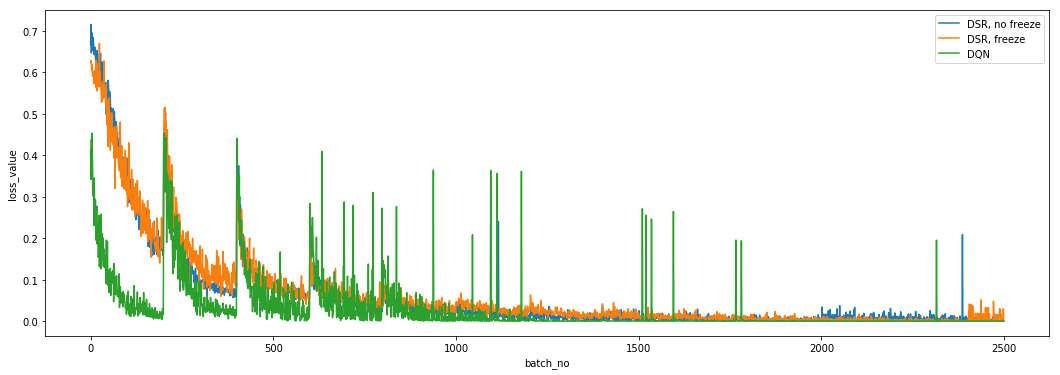

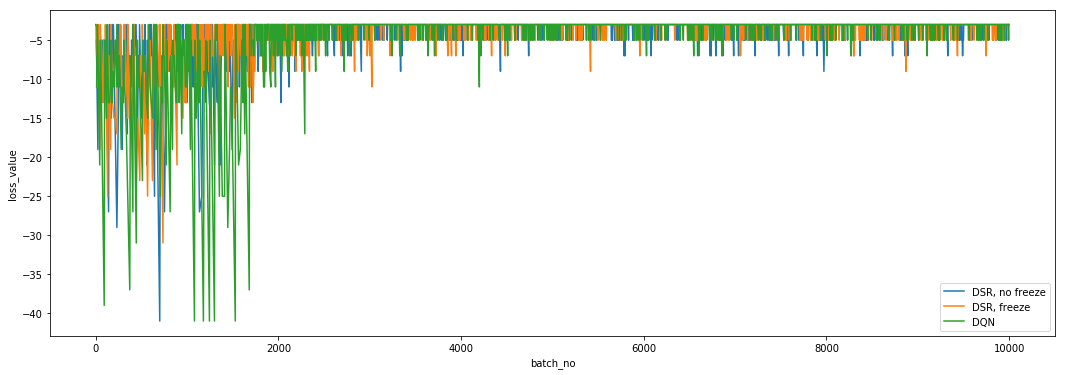

In [12]:
plt.figure(figsize=(18,6))
plt.plot(dsr1.loss_vec, label='DSR, f0')
plt.plot(dsr2.loss_vec, label='DSR, f1')
plt.plot(dqn.loss_vec, label='DQN')
plt.xlabel('batch_no'), plt.ylabel('loss_value')
plt.legend()

plt.figure(figsize=(18,6))
plt.plot(np.array(dsr1.returns)[:,0], np.array(dsr1.returns)[:,1], label='DSR, f0')
plt.plot(np.array(dsr2.returns)[:,0], np.array(dsr2.returns)[:,1], label='DSR, f1')
plt.plot(np.array(dqn.returns)[:,0], np.array(dqn.returns)[:,1], label='DQN')
plt.xlabel('batch_no'), plt.ylabel('loss_value')
plt.legend()

2020-04-16 19:57:14,577 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


SRNet(
  (body): SRIdentityBody()
  (layers): ModuleList(
    (0): Linear(in_features=7, out_features=14, bias=True)
  )
  (psi2q): Psi2QNet()
)


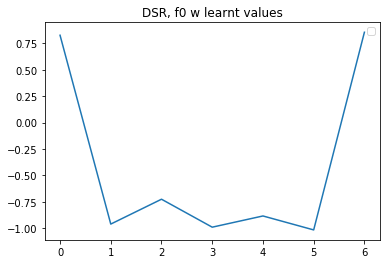

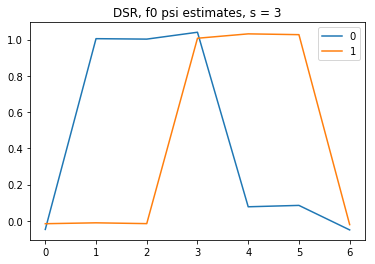

2020-04-16 19:57:15,037 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


Qvalue estiamtes:  [[-1.6518056 -1.4280388]
 [-1.0030737 -2.9402318]
 [-1.9897379 -3.9409657]
 [-2.9619472 -2.9637408]
 [-3.9380028 -1.9937518]
 [-2.9648952 -1.0005965]
 [-1.558629  -1.8166281]]


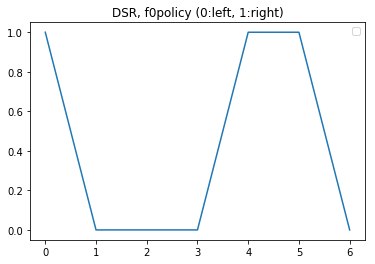

2020-04-16 19:57:15,249 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


SRNet(
  (body): SRIdentityBody()
  (layers): ModuleList(
    (0): Linear(in_features=7, out_features=14, bias=True)
  )
  (psi2q): Psi2QNet()
)


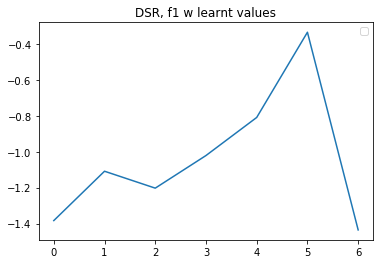

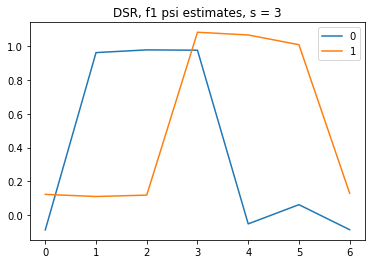

2020-04-16 19:57:15,702 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


Qvalue estiamtes:  [[-1.8314704  -1.3515381 ]
 [-0.99972874 -2.960966  ]
 [-1.9939255  -3.9253342 ]
 [-2.977992   -2.9301934 ]
 [-3.9222996  -1.9626011 ]
 [-2.961769   -0.9937498 ]
 [-3.3171246  -0.7336895 ]]


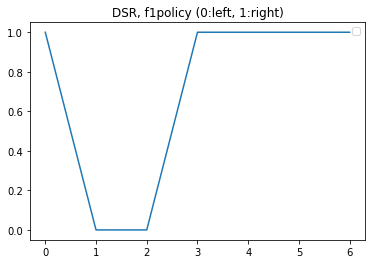

2020-04-16 19:57:15,946 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


VanillaNet(
  (fc_head): Linear(in_features=13, out_features=2, bias=True)
  (body): FCBody(
    (layers): ModuleList(
      (0): Linear(in_features=7, out_features=13, bias=True)
    )
  )
)
Qvalue estiamtes:  [[-2.6963105  -1.640981  ]
 [-0.9978739  -2.966359  ]
 [-1.9908578  -3.9318433 ]
 [-2.971744   -2.9691708 ]
 [-3.9279265  -1.9897876 ]
 [-2.974653   -0.99997455]
 [-2.0961716  -0.9743619 ]]


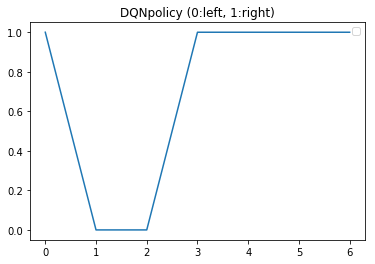

In [13]:
sanity(dsr1, is_dsr=True, title='DSR, f0')
sanity(dsr2, is_dsr=True, title='DSR, f1')
sanity(dqn, is_dsr=False, title='DQN')

## Part 2: Train an avSR initialization 

In [8]:
agents, _, _ = runNAgents(dqn_feature, runs=1, store=True)

runs: 100%|██████████| 1/1 [00:10<00:00, 10.74s/it]


In [9]:
def avdsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(0.1, 0.1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e4
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [11]:
avdsr = avdsr_feature(game='LineWorld', agents=agents)

2020-04-17 10:26:29,254 - root - INFO: steps 0, 116508444.44 steps/s
2020-04-17 10:26:30,395 - root - INFO: steps 1000, 878.11 steps/s
2020-04-17 10:26:31,851 - root - INFO: steps 2000, 687.53 steps/s
2020-04-17 10:26:33,186 - root - INFO: steps 3000, 750.13 steps/s
2020-04-17 10:26:34,513 - root - INFO: steps 4000, 754.27 steps/s
2020-04-17 10:26:35,981 - root - INFO: steps 5000, 681.89 steps/s
2020-04-17 10:26:37,303 - root - INFO: steps 6000, 757.31 steps/s
2020-04-17 10:26:38,588 - root - INFO: steps 7000, 779.43 steps/s
2020-04-17 10:26:39,887 - root - INFO: steps 8000, 770.43 steps/s
2020-04-17 10:26:41,166 - root - INFO: steps 9000, 782.66 steps/s
2020-04-17 10:26:42,712 - root - INFO: steps 10000, 647.20 steps/s


Text(0.5,1,'DSR prediction loss goes down')

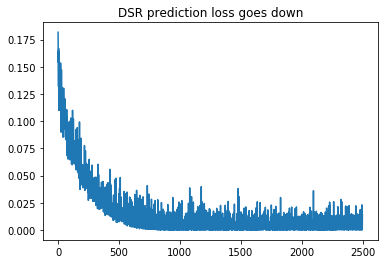

In [19]:
plt.plot(avdsr.loss_vec)
plt.title('DSR prediction loss goes down')

In [ ]:
sanity(avdsr)

## Part 3: Train N agents of all styles on same environment and compare results

In [7]:
def runNAgents(function, runs, store=False, freeze=0, ref=None):
    r_dqn = []; t_dqn = []
    if(store):
        agents = []
    for i in trange(runs, desc='runs'): 
        agent = function(game='LineWorld', freeze=freeze, ref=ref)
        rewards = np.array(agent.returns)
        t_dqn.append(rewards[:,0])
        r_dqn.append(rewards[:,1])
        if(store):
            agents.append(agent)
            
    if(store):
        return agents, t_dqn, r_dqn
    
    return t_dqn, r_dqn

In [15]:
r_avdsr3 = runNAgents(dsr_feature_init, 10, freeze=2, ref=avdsr)

runs:   0%|          | 0/10 [00:00<?, ?it/s]2020-04-17 10:27:34,614 - root - INFO: steps 0, episodic_return_test -3.00(0.00)
2020-04-17 10:27:41,106 - root - INFO: steps 5000, episodic_return_test -3.00(0.00)
2020-04-17 10:27:47,955 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)
runs:  10%|█         | 1/10 [00:13<02:01, 13.54s/it]2020-04-17 10:27:48,409 - root - INFO: steps 0, episodic_return_test -3.00(0.00)
2020-04-17 10:27:58,570 - root - INFO: steps 5000, episodic_return_test -3.00(0.00)
2020-04-17 10:28:12,839 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)
runs:  20%|██        | 2/10 [00:38<02:15, 16.94s/it]2020-04-17 10:28:13,063 - root - INFO: steps 0, episodic_return_test -3.00(0.00)
2020-04-17 10:28:23,047 - root - INFO: steps 5000, episodic_return_test -3.00(0.00)
2020-04-17 10:28:32,961 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)
runs:  30%|███       | 3/10 [00:58<02:05, 17.90s/it]2020-04-17 10:28:33,197 - root - INFO: steps 0, ep

In [31]:
r_dsr1 = runNAgents(dsr_feature, 10, freeze=0)
r_dsr2 = runNAgents(dsr_feature, 10, freeze=1)
r_dqn = runNAgents(dqn_feature, 10)
r_avdsr1 = runNAgents(dsr_feature_init, 10, freeze=0, ref=avdsr)
r_avdsr2 = runNAgents(dsr_feature_init, 10, freeze=1, ref=avdsr)
r_avdsr3 = runNAgents(dsr_feature_init, 10, freeze=2, ref=avdsr)

runs:   0%|          | 0/10 [00:00<?, ?it/s]2020-04-16 20:27:42,717 - root - INFO: steps 0, episodic_return_test -3.00(0.00)
2020-04-16 20:27:53,265 - root - INFO: steps 5000, episodic_return_test -3.00(0.00)
2020-04-16 20:28:03,030 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)
runs:  10%|█         | 1/10 [00:20<03:04, 20.54s/it]2020-04-16 20:28:03,341 - root - INFO: steps 0, episodic_return_test -3.00(0.00)
2020-04-16 20:28:21,444 - root - INFO: steps 5000, episodic_return_test -3.00(0.00)
2020-04-16 20:28:34,252 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)
runs:  20%|██        | 2/10 [00:51<03:09, 23.74s/it]2020-04-16 20:28:34,529 - root - INFO: steps 0, episodic_return_test -3.00(0.00)
2020-04-16 20:28:49,435 - root - INFO: steps 5000, episodic_return_test -3.00(0.00)
2020-04-16 20:29:04,759 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)
runs:  30%|███       | 3/10 [01:22<03:00, 25.78s/it]2020-04-16 20:29:05,241 - root - INFO: steps 0, ep

2020-04-16 20:50:04,242 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)
runs:  70%|███████   | 7/10 [02:35<01:02, 20.91s/it]2020-04-16 20:50:04,460 - root - INFO: steps 0, episodic_return_test -3.00(0.00)
2020-04-16 20:50:14,688 - root - INFO: steps 5000, episodic_return_test -3.00(0.00)
2020-04-16 20:50:23,374 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)
runs:  80%|████████  | 8/10 [02:54<00:40, 20.38s/it]2020-04-16 20:50:23,600 - root - INFO: steps 0, episodic_return_test -3.00(0.00)
2020-04-16 20:50:32,061 - root - INFO: steps 5000, episodic_return_test -3.00(0.00)
2020-04-16 20:50:40,059 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)
runs:  90%|█████████ | 9/10 [03:11<00:19, 19.27s/it]2020-04-16 20:50:40,263 - root - INFO: steps 0, episodic_return_test -3.00(0.00)
2020-04-16 20:50:48,179 - root - INFO: steps 5000, episodic_return_test -3.00(0.00)
2020-04-16 20:50:56,559 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)
runs:   0

OSError: [Errno 24] Too many open files

In [14]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        agent.network.load_state_dict(ref.network.state_dict())
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

In [16]:
def plot_rewards(rewards, plot_seperate=True , clip=10000, title='unnamed'):
    
    colors = ['red', 'blue', 'green', 'm', 'k', 'y', '#999999']
    
    plt.figure(figsize=(18,6))
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = np.interp(np.arange(clip), t, r)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.xlabel('timesteps'), plt.ylabel('episodic returns')
    plt.title(title)
    plt.legend(), plt.show()

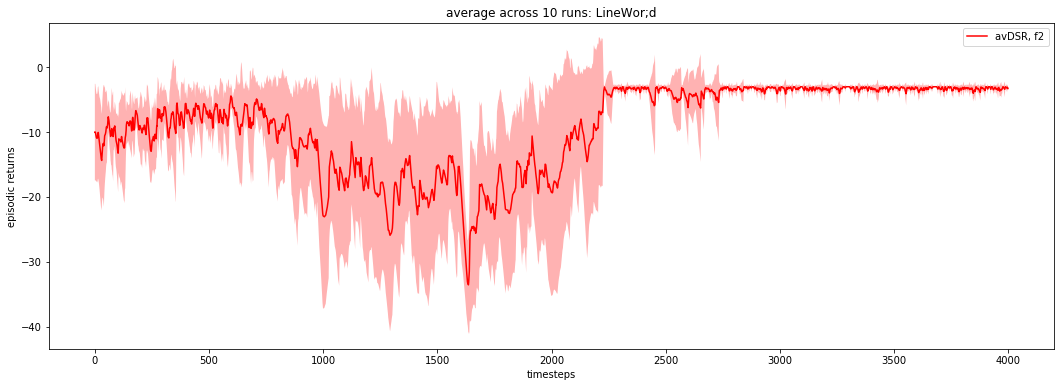

In [18]:
# rewards_dict = {'DSR, f0': r_dsr1, 'DSR, f1': r_dsr2, 'DQN': r_dqn,
#                'avDSR, f0': r_avdsr1, 'avDSR, f1': r_avdsr2}
rewards_dict = {'avDSR, f2': r_avdsr3}
# plot_rewards(rewards_dict, plot_seperate=True, clip=2000)
plot_rewards(rewards_dict, plot_seperate=False, clip=4000, title='average across 10 runs: LineWor;d')

### DSR base code

In [7]:
#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

"""
DQN code modified to convert it to DSR by Surya.
The representations are not learned in this network.
"""


class DSRActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            _, psi, q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DSRAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []
        self.returns = []

        self.replay = config.replay_fn()
        self.actor = DSRActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.w_optimizer = config.optimizer_fn(self.network.psi2q.parameters()) # only on w's

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:

            # Reporting training progress on stdout
            # self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
                    
            self.total_steps += 1
            reward = config.reward_normalizer(reward)

            # Putting these new entries in experiences
            experiences.append([state, action, reward, next_state, done])

        # Add experiences to replay
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Sampling from replay buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences

            # Normalizing stat values
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Computing targets
            _, psi_next, q_next = self.target_network(next_states)
            psi_next = psi_next.detach()
            q_next = q_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1) # predicts max q values (vector of b) and corresponding arguments
                a_star = q_next[1]
                q_next = q_next[0]
                psi_next = psi_next[self.batch_indices, a_star, :]

            terminals = tensor(terminals)
            rewards = tensor(rewards)

            # Estimate q target
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)

            # Estimate psi target (obtained from target n/w) # CHECK: should we get target from network instead?
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.target_network(next_states)[0]) # Adding the prediction for present state.

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, q = self.network(states)
            q = q[self.batch_indices, actions]
            psi = psi[self.batch_indices, actions, :]

            # Estimating the loss
            loss_q = (q_next - q).pow(2).mul(0.5).mean()
            loss_psi = config.c * (psi_next - psi).pow(2).mul(0.5).mean()
            loss = loss_q + loss_psi
            
            # Storing loss estimates
            self.loss_vec.append(loss.item())
            self.loss_q_vec.append(loss_q.item())
            self.loss_psi_vec.append(loss_psi.item())
            
            if(not np.isfinite(loss.item())):
                print(' loss has diverged!')
                import pdb;pdb.set_trace()
                return 
            
            # Update all
            self.optimizer.zero_grad()
            loss.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.optimizer.step()
                
            # Update w parameters
#             self.w_optimizer.zero_grad()
#             loss_q.backward()
#             nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
#             with config.lock:
#                 self.w_optimizer.step()
                
            

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

### DSR with seperate loss training

In [8]:
#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

"""
DQN code modified to convert it to DSR by Surya.
The representations are not learned in this network.
"""


class DSRActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            _, psi, q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DSRAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []
        self.returns = []

        self.replay = config.replay_fn()
        self.actor = DSRActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.w_optimizer = config.optimizer_fn(self.network.psi2q.parameters()) # only on w's

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:

            # Reporting training progress on stdout
            # self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
                    
            self.total_steps += 1
            reward = config.reward_normalizer(reward)

            # Putting these new entries in experiences
            experiences.append([state, action, reward, next_state, done])

        # Add experiences to replay
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Sampling from replay buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences

            # Normalizing stat values
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Computing targets
            _, psi_next, q_next = self.target_network(next_states)
            psi_next = psi_next.detach()
            q_next = q_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1) # predicts max q values (vector of b) and corresponding arguments
                a_star = q_next[1]
                q_next = q_next[0]
                psi_next = psi_next[self.batch_indices, a_star, :]

            terminals = tensor(terminals)
            rewards = tensor(rewards)

            # Estimate q target
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)

            # Estimate psi target (obtained from target n/w) # CHECK: should we get target from network instead?
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.target_network(next_states)[0]) # Adding the prediction for present state.

            # Computing estimates
            actions = tensor(actions).long()
            _, psi, q = self.network(states)
            q = q[self.batch_indices, actions]
            psi = psi[self.batch_indices, actions, :]

            # Estimating the loss
            loss_q = (q_next - q).pow(2).mul(0.5).mean()
            loss_psi = config.c * (psi_next - psi).pow(2).mul(0.5).mean()
            loss = loss_q + loss_psi
            
            # Storing loss estimates
            self.loss_vec.append(loss.item())
            self.loss_q_vec.append(loss_q.item())
            self.loss_psi_vec.append(loss_psi.item())
            
            if(not np.isfinite(loss.item())):
                print(' loss has diverged!')
                import pdb;pdb.set_trace()
                return 
            
            # Update all except w
            self.optimizer.zero_grad()
            loss_psi.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.optimizer.step()
                
            # Update w parameters
            self.w_optimizer.zero_grad()
            loss_q.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.w_optimizer.step()
                
            

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

### DSR main function

In [9]:
def dsr_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1
    config.freeze = False

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e4
    config.async_actor = False
    
    # Train an agent with the above config
    agent = DSRAgent(config)
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

In [10]:
### Plotting the results
def convolve(points, kernelSize=5):
    array = np.convolve(points, np.ones(kernelSize), 'valid')
    return array

def plot_dqn(obj, title = 'DQN'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(311)
    plt.plot(convolve(obj.loss_vec, kernelSize=11)/11)
    plt.title(title+' loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(312)
    plt.plot(convolve(obj.loss_vec, kernelSize=111)/111)
    plt.title(title+' smoothed loss ')
    plt.ylabel('loss value'), plt.xlabel('batch no')
    plt.subplot(313)
    plt.plot(np.array(obj.returns)[:,0],np.array(obj.returns)[:,1])
    plt.xlabel('timesteps'), plt.ylabel('return')
    plt.title(title+' training performance')
    plt.show()

def plot_dsr(obj, title='DSR'):
    plt.figure(figsize=(12,12),dpi=100)
    plt.subplot(211)
    plt.plot(convolve(obj.loss_q_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss q value'), plt.xlabel('batch no')
    plt.subplot(212)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')
    
def plot_dsr2(obj, title='DSR'):
    plt.figure(figsize=(12,4),dpi=100)
    plt.plot(convolve(obj.loss_psi_vec, kernelSize=11)/11)
    plt.title(title+' loss')
    plt.ylabel('loss psi value'), plt.xlabel('batch no')

In [11]:
from deep_rl.component.lineworld import LineWorld
env = LineWorld()

def _visualize_vector(vector, title="unnamed", show_goal=False, show=True, label=""):
    plt.plot(vector, label=label)
    plt.title(title)
    if show:
        plt.legend()
        plt.show()
        
def sanity(agent):
    
    print(agent.network)
    
    # Setting things up
    env = LineWorld()
    
    # Visualize w
    w_vector = agent.network.state_dict()['psi2q.w'].numpy()
    _visualize_vector(w_vector, title="w learnt values")
    
    # Visualize psi
    states = [3]
    plt.figure(figsize=(len(states)*12, 5))
    
    for i, s in enumerate(states):
        temp = np.zeros(env.n)
        temp[s] = 1
        phi, psi, q = agent.network(tensor(temp).unsqueeze(0))
        psi = psi.detach().numpy()
        q = q.detach().numpy().flatten()
        _visualize_vector(psi[:,0,:].flatten(), title="q({},{})={}".format(s, 0, q[0]), show=False, label="0")
        _visualize_vector(psi[:,1,:].flatten(), title="psi estimates, s = {}".format(s), show=True, label="1")
            
    # Visualize policy
    state_space = np.identity(env.n)
    phi, psi, q = agent.network(tensor(state_space))
    optimal_actions = q.max(1)[1].detach().numpy()
#     import pdb; pdb.set_trace()
    _visualize_vector(optimal_actions, title='policy (0:left, 1:right)')

    plt.show()

### Run DSR agent

In [12]:
a = dsr_feature(game='LineWorld')

2020-04-16 13:04:19,204 - root - INFO: steps 0, episodic_return_test -3.00(0.00)
2020-04-16 13:04:28,043 - root - INFO: steps 5000, episodic_return_test -3.00(0.00)
2020-04-16 13:04:34,996 - root - INFO: steps 10000, episodic_return_test -3.00(0.00)


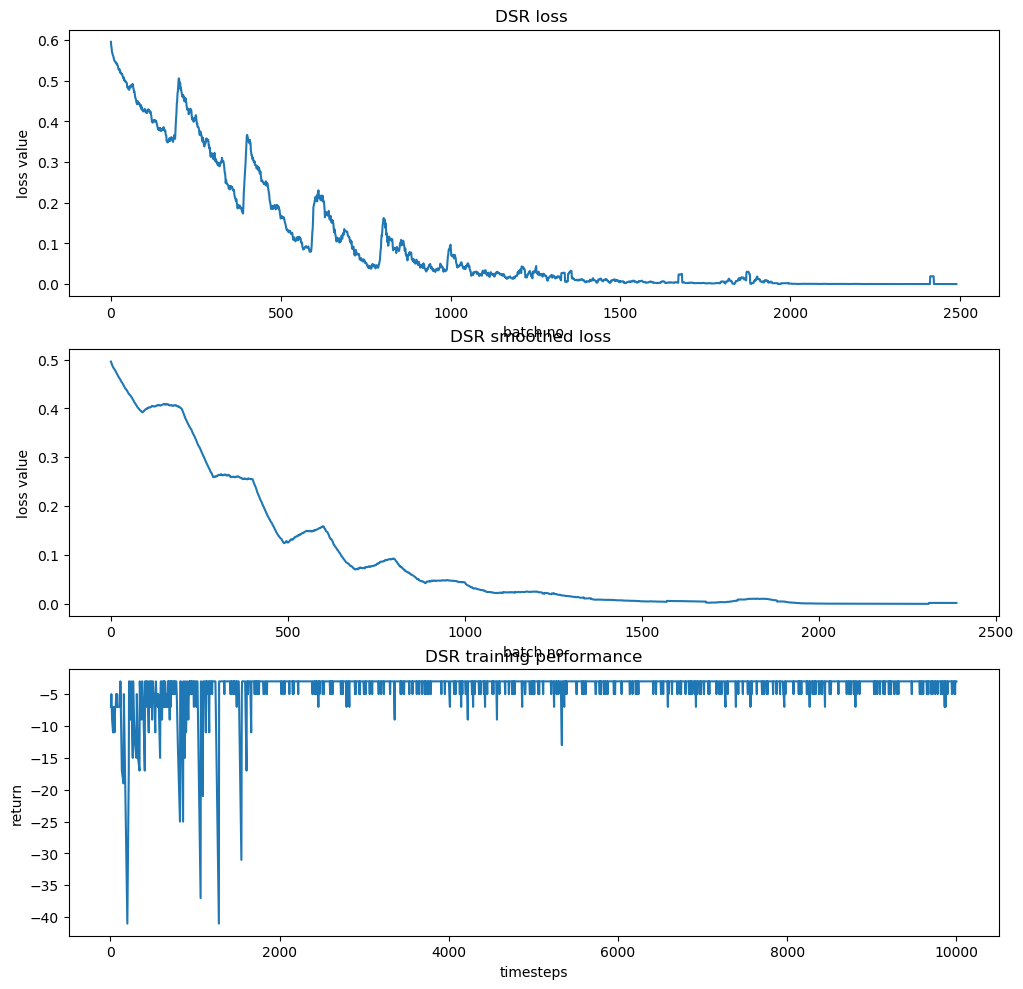

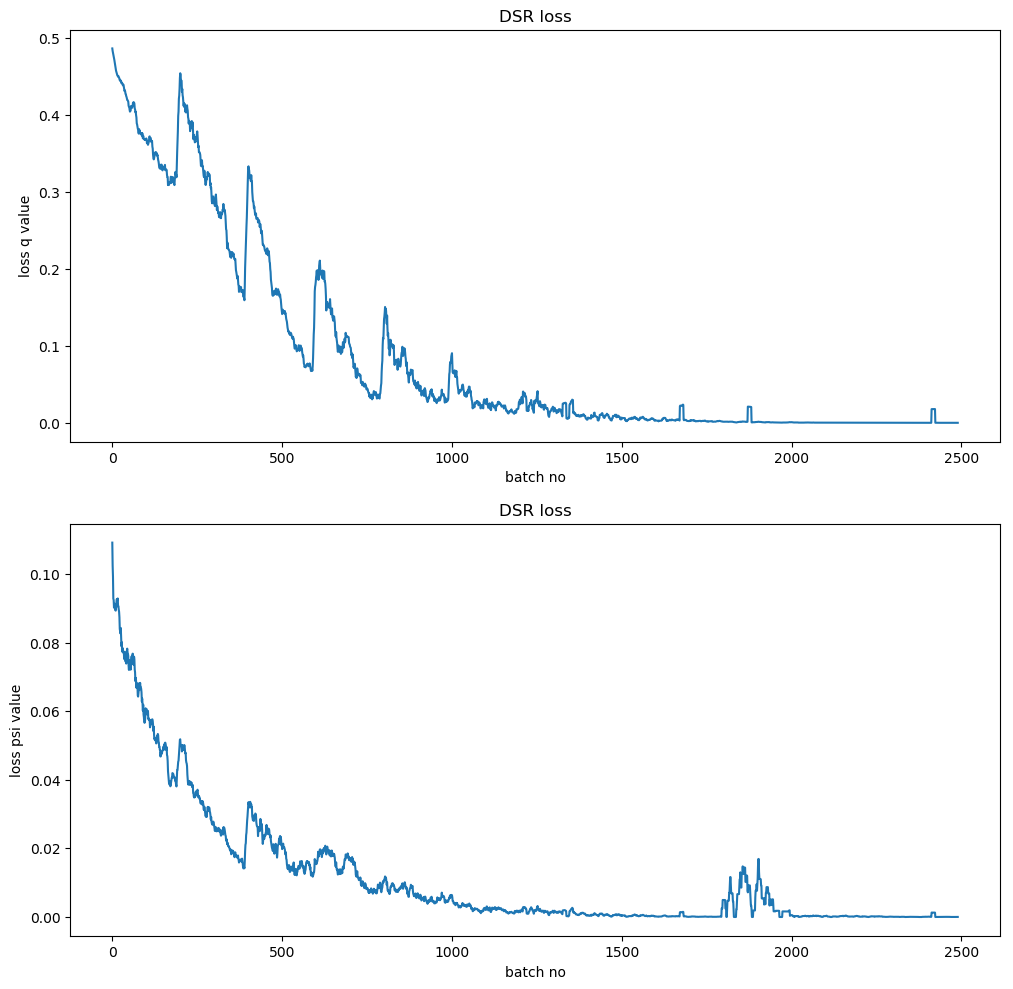

In [13]:
plot_dqn(a, title='DSR')
plot_dsr(a, title='DSR')

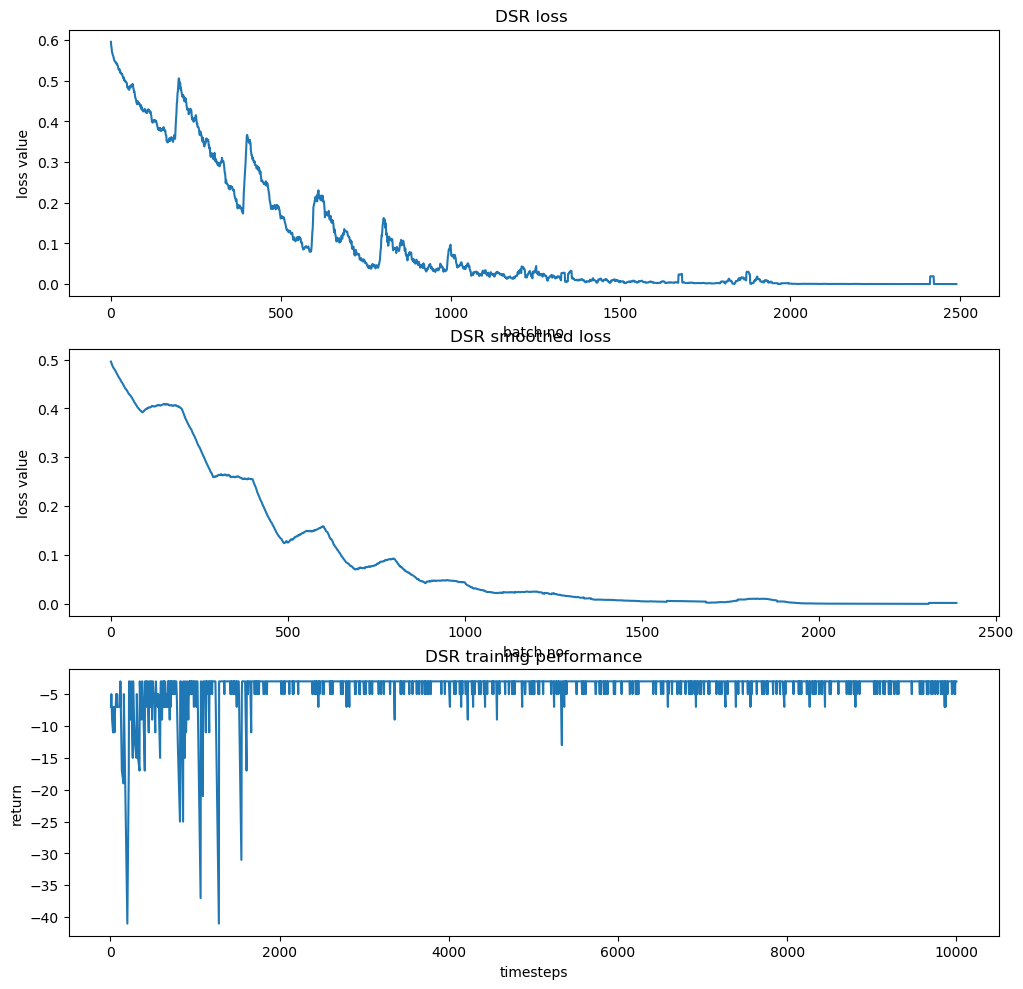

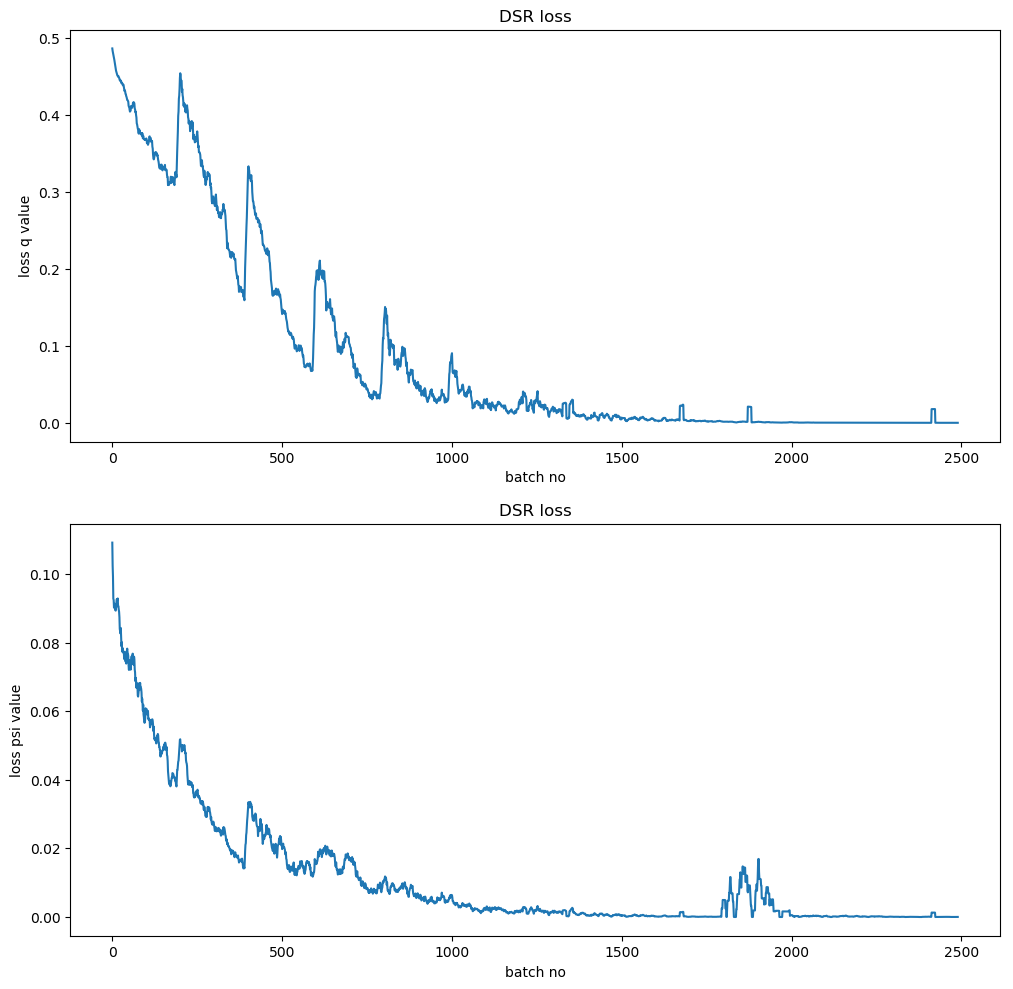

In [14]:
plot_dqn(a, title='DSR')
plot_dsr(a, title='DSR')

2020-04-16 13:04:39,457 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


SRNet(
  (body): SRIdentityBody()
  (layers): ModuleList(
    (0): Linear(in_features=7, out_features=14, bias=True)
  )
  (psi2q): Psi2QNet()
)


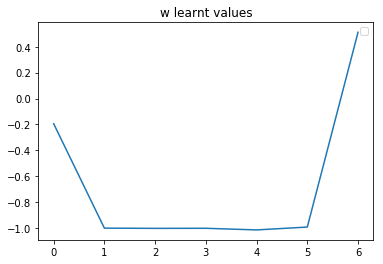

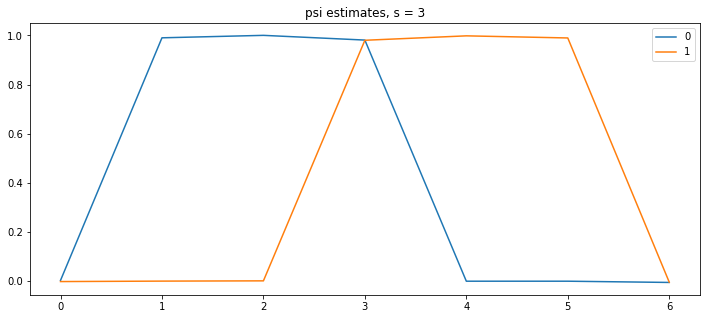

2020-04-16 13:04:40,336 - matplotlib.legend - WARNING: No handles with labels found to put in legend.


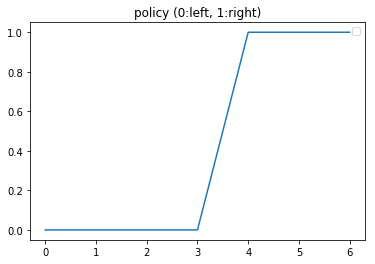

In [15]:
sanity(a)

### Run DQN agent

In [16]:
class DQNActor(BaseActor):
    def __init__(self, config):
        BaseActor.__init__(self, config)
        self.config = config
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        with config.lock:
            q_values = self._network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
        next_state, reward, done, info = self._task.step([action])
        entry = [self._state[0], action, reward[0], next_state[0], int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class DQNAgent(BaseAgent):
    def __init__(self, config):
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()

        self.returns = []
        
        self.replay = config.replay_fn()
        self.actor = DQNActor(config)

        self.network = config.network_fn()
        self.network.share_memory()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.network.state_dict())
        self.optimizer = config.optimizer_fn(self.network.parameters())
        self.loss_vec = []

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size)

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, done, info in transitions:
#             self.record_online_return(info)
            
            # Recording train returns in list
            for i, info_ in enumerate(info):
                ret = info_['episodic_return']
                if ret is not None:
                    self.returns.append([self.total_steps, ret])
            
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, done])
        self.replay.feed_batch(experiences)

        if self.total_steps > self.config.exploration_steps:
            experiences = self.replay.sample()
            states, actions, rewards, next_states, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)
            q_next = self.target_network(next_states).detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                q_next = q_next.max(1)[0]
            terminals = tensor(terminals)
            rewards = tensor(rewards)
            q_next = self.config.discount * q_next * (1 - terminals)
            q_next.add_(rewards)
            actions = tensor(actions).long()
            q = self.network(states)
            q = q[self.batch_indices, actions]
            loss = (q_next - q).pow(2).mul(0.5).mean()
            self.loss_vec.append(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)
            with config.lock:
                self.optimizer.step()

        if self.total_steps / self.config.sgd_update_frequency % \
                self.config.target_network_update_freq == 0:
            self.target_network.load_state_dict(self.network.state_dict())

# DQN
def dqn_feature(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e4
    config.async_actor = False
    agent = DQNAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
#             agent.eval_episodes()
            pass
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
    return agent

In [17]:
agent_dqn = dqn_feature(game='LineWorld')

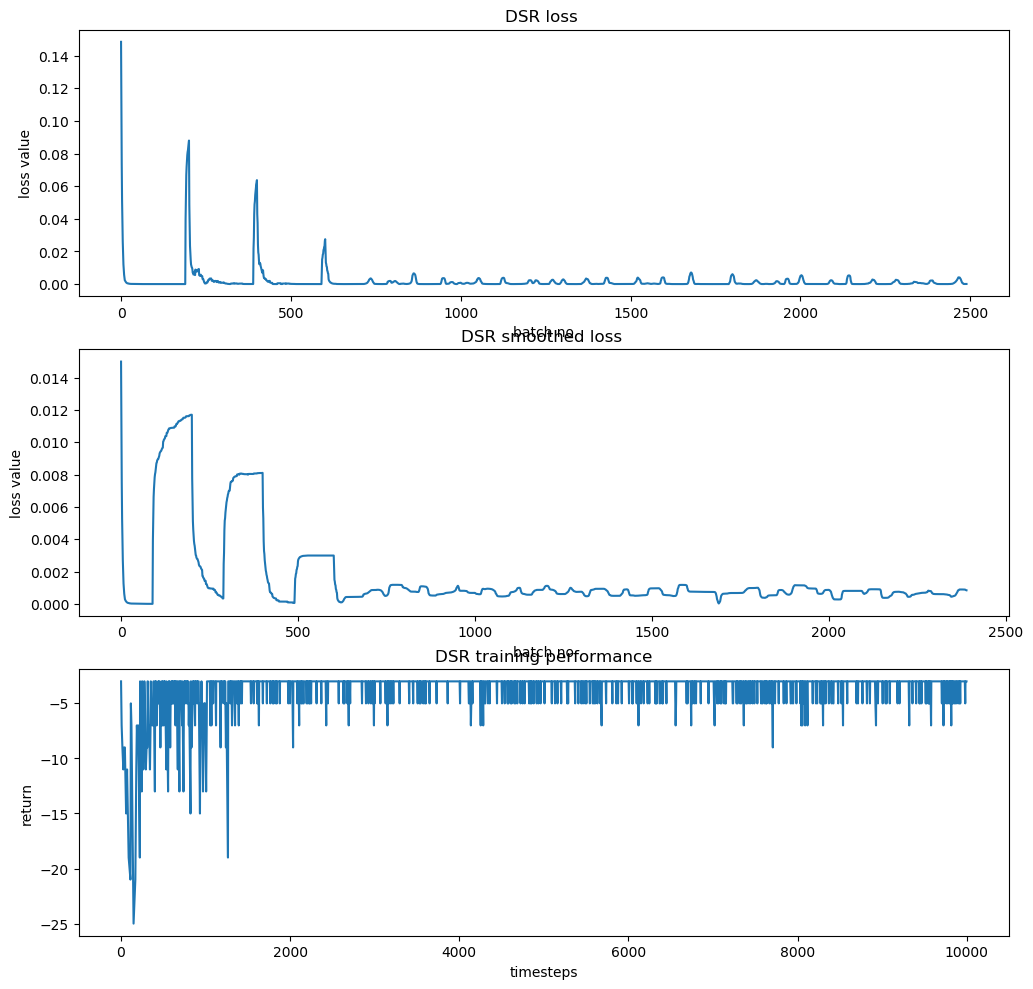

In [18]:
plot_dqn(agent_dqn, title='DSR')
# sanity(agent_dqn)

### Experiments on avSR

In [19]:
import random
"""
Code for learning the averageSR agent across good policies.
"""


class avDSRActor(BaseActor):
    def __init__(self, config, agents, style='DQN'):
        BaseActor.__init__(self, config)
        self.config = config
        self.agents = agents
        self.style = style
        self.start()

    def _transition(self):
        if self._state is None:
            self._state = self._task.reset()
        config = self.config
        

        # Choose one of the base agents randomly
        pick = random.choice(self.agents)

        # Find qvalues of the picked agent for the present state
        with config.lock:
            if(self.style == 'DSR'):
                _, _, q_values = pick.network(config.state_normalizer(self._state))
            else:
                q_values = pick.network(config.state_normalizer(self._state))
        q_values = to_np(q_values).flatten()

        # Take action based on this estimated q value
        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            action = np.random.randint(0, len(q_values))
        else:
            action = np.argmax(q_values)
            
        next_state, reward, done, info = self._task.step([action])
        
        # Also estimate next action
        #############
        pick2 = random.choice(self.agents)
        with config.lock:
            if(self.style == 'DSR'):
                _, _, q_values = pick2.network(config.state_normalizer(next_state))
            else:
                q_values = pick2.network(config.state_normalizer(next_state))
        q_values = to_np(q_values).flatten()

        if self._total_steps < config.exploration_steps \
                or np.random.rand() < config.random_action_prob():
            next_action = np.random.randint(0, len(q_values))
        else:
            next_action = np.argmax(q_values)
        
        entry = [self._state[0], action, reward[0], next_state[0], next_action, int(done[0]), info]
        self._total_steps += 1
        self._state = next_state
        return entry


class avDSRAgent(BaseAgent):
    def __init__(self, config, agents, style='DQN'):
        """
        agents -> list of agents whose actions we need to consider.
        """
        BaseAgent.__init__(self, config)
        self.config = config
        config.lock = mp.Lock()
        
        self.loss_q_vec = []
        self.loss_psi_vec = []
        self.loss_vec = []

        self.replay = config.replay_fn()
        self.actor = avDSRActor(config, agents, style)

        self.network = config.network_fn()
        self.network.share_memory()
        self.optimizer = config.optimizer_fn(self.network.parameters())

        self.actor.set_network(self.network)

        self.total_steps = 0
        self.batch_indices = range_tensor(self.replay.batch_size) # Need to make this size bigger

    def close(self):
        close_obj(self.replay)
        close_obj(self.actor)

    def eval_step(self, state):
        self.config.state_normalizer.set_read_only()
        state = self.config.state_normalizer(state)
        _, _, q = self.network(state)
        action = to_np(q.argmax(-1))
        self.config.state_normalizer.unset_read_only()
        return action

    def step(self):
        config = self.config

        # Store transitions in the buffer
        transitions = self.actor.step()
        experiences = []
        for state, action, reward, next_state, next_action, done, info in transitions:
#             self.record_online_return(info)
            self.total_steps += 1
            reward = config.reward_normalizer(reward)
            experiences.append([state, action, reward, next_state, next_action, done])
        self.replay.feed_batch(experiences)

        # Start updating network parameters after exploration_steps
        if self.total_steps > self.config.exploration_steps:

            # Getting samples from buffer
            experiences = self.replay.sample()
            states, actions, rewards, next_states, next_actions, terminals = experiences
            states = self.config.state_normalizer(states)
            next_states = self.config.state_normalizer(next_states)

            # Estimate targets
            with torch.no_grad():
                _, psi_next, _ = self.network(next_states)
            psi_next = psi_next.detach()
            if self.config.double_q:
                best_actions = torch.argmax(self.network(next_states), dim=-1)
                q_next = q_next[self.batch_indices, best_actions]
            else:
                next_actions = tensor(next_actions).long()
                psi_next = psi_next[self.batch_indices, next_actions, :] # TODO: double check dims here

            terminals = tensor(terminals)
            psi_next = self.config.discount * psi_next * (1 - terminals.unsqueeze(1).repeat(1, psi_next.shape[1]))
            psi_next.add_(self.network(states)[0]) # TODO: double chec this
            # Computing estimates
            actions = tensor(actions).long()
            _, psi, _ = self.network(states)
            psi = psi[self.batch_indices, actions, :]
            
            
#             loss_psi = (psi_next - psi).pow(2).mul(0.5).mean(0)
            loss_psi = (psi_next - psi).pow(2).mul(0.5).mean()

            loss = loss_psi
            
            total_loss = loss.mean()
            self.loss_vec.append(total_loss.item())
            self.loss_psi_vec.append(total_loss.item())
            
            
            self.optimizer.zero_grad()
#             loss.backward(torch.ones(loss.shape))
            loss.backward()

            nn.utils.clip_grad_norm_(self.network.parameters(), self.config.gradient_clip)

            with config.lock:
                self.optimizer.step()


In [20]:
def avDSR(**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
#     config.optimizer_fn = lambda params: torch.optim.SGD(params, lr=0.001)

    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(0.1, 0.1, 1e4) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = 1e4
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    while True:
        if config.log_interval and not agent.total_steps % config.log_interval:
            agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()

In [21]:
agent_k1 = avDSR(game='LineWorld', agents=[a])
agent_k2 = avDSR(game='LineWorld', agents=[a])

NameError: name 'SRNet_backup' is not defined

In [ ]:
plot_dsr2(agent_k1, 'avDSR prediction')
plot_dsr2(agent_k2, 'avDSR prediction')

### Train new agent with avDSR initialization

In [ ]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 10

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.001)
    config.network_fn = lambda: SRNet_backup(config.action_dim, SRIdentityBody(config.state_dim))
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
#                         Phi2Psi(config.state_dim, config.action_dim, hidden_units=(104,)))
    # config.network_fn = lambda: DuelingNet(config.action_dim, FCBody(config.state_dim))
    # config.replay_fn = lambda: Replay(memory_size=int(1e4), batch_size=10)
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e4), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, 1e3)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = 1e4
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        agent.network.load_state_dict(ref.network.state_dict())
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
        agent.step()
        agent.switch_task()
        
    return agent

In [ ]:
from tqdm import trange, tqdm
r_vec_av = []; t_vec_av = []
for i in trange(5, desc='runs'): 
    agent_f = dsr_feature_init(ref=agent_k1, game='LineWorld')
    rewards = np.array(agent_f.returns)
    t_vec_av.append(rewards[:,0])
    r_vec_av.append(rewards[:,1])

In [ ]:
r_vec_dsr = []; t_vec_dsr = []
for i in trange(5, desc='runs'): 
    agent_dsr = dsr_feature(game='LineWorld')
    rewards = np.array(agent_dsr.returns)
    t_vec_dsr.append(rewards[:,0])
    r_vec_dsr.append(rewards[:,1])

In [ ]:
r_vec_dqn = []; t_vec_dqn = []
for i in trange(5, desc='runs'): 
    agent_dqn = dqn_feature(game='LineWorld')
    rewards = np.array(agent_dqn.returns)
    t_vec_dqn.append(rewards[:,0])
    r_vec_dqn.append(rewards[:,1])

In [ ]:
def plot_rewards(rewards, plot_seperate=True , clip=10000):
    
    colors = ['red', 'blue', 'green', '#999999']
    
    plt.figure(figsize=(18,6))
    if(plot_seperate):
        for k, v in rewards.items():
            for t, r in zip(v[0], v[1]):
                plt.plot(t, r, label=k)
        plt.legend(), plt.show()
        return
    
    for j, (k, v) in enumerate(rewards.items()):
        r_vec = np.zeros((len(v[0]), clip))
        for i, (t, r) in enumerate(zip(v[0], v[1])):
            r_vec[i,:] = np.interp(np.arange(clip), t, r)
    
        mean = np.mean(np.array(r_vec), axis=0)
        std = np.std(np.array(r_vec), axis=0)
        plt.plot(mean, label=k, color=colors[j])
        plt.fill_between(np.arange(0, len(mean)), mean+std, mean-std, facecolor=colors[j], alpha=0.3)
    
    plt.legend(), plt.show()

In [ ]:
rewards_dict = {'avInit': (t_vec_av, r_vec_av),
              'DSR': (t_vec_dsr, r_vec_dsr),
               'DQN': (t_vec_dqn, r_vec_dqn)}
plot_rewards(rewards_dict, plot_seperate=False, clip=2000)